# Analysis of Error Bound for Smooth Markets
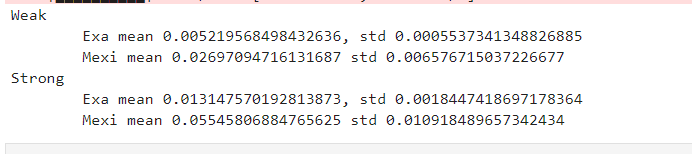

In [1]:
import os
import sys
import numpy as np
from time import perf_counter as timer
import json

root_path = os.path.join(os.path.expanduser('~'), 'bnelearn')
if root_path not in sys.path:
    sys.path.append(root_path)

from scipy import interpolate

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
    
import bnelearn
from bnelearn.experiment.configuration_manager import ConfigurationManager
import bnelearn.util.metrics as metrics

BNE envs have been set up.


In [2]:
COLORS = ("#0E6BA0", "#973D4C", "#30C0D2", 'blue', 'green')
MARKERS = ("^", "s", "D")

In [3]:
specific_gpu = 2
torch.cuda.set_device(specific_gpu)

log_root_dir = os.path.join(os.path.expanduser('~'), 'bnelearn', 'experiments',
                            'smooth-variance')

In [4]:
n_runs = 5
n_iters = 500
temperatures = np.linspace(0.001, 0.05, 20)
population_sizes = [64]

In [5]:
def run_experiment_and_get_variance(learner, temperature, population_size):
    experiment_config, experiment_class = \
        ConfigurationManager(
            experiment_type='single_item_uniform_symmetric',
            n_runs=n_runs, n_epochs=n_iters
        ) \
        .set_learning(
            batch_size=2**16,
            pretrain_iters=50,
            learner_type=learner,
            learner_hyperparams={
                'population_size': population_size,
                'sigma': 1.,
                'scale_sigma_by_model_size': True
            },
            smoothing_temperature=temperature
        ) \
        .set_logging(
            log_root_dir=log_root_dir,
            save_tb_events_to_csv_detailed=True,
            log_metrics={
                'opt': True,
                'util_loss': True,
                'gradient_variance': True
                }
        ) \
        .set_hardware(specific_gpu=specific_gpu) \
        .get_config()
    experiment = experiment_class(experiment_config)
    experiment.run()

    # Read in logged data
    df = pd.read_csv(f"{experiment.experiment_log_dir}/full_results.csv")
    gradient_variance = df[df["tag"] == "learner_info/gradient_variance"].value

    return gradient_variance

In [6]:
%%capture
variance_mean = np.zeros((2, len(temperatures), len(population_sizes)))
variance_std = np.zeros((2, len(temperatures), len(population_sizes)))

for j, learner in enumerate(['PGLearner', 'ESPGLearner']):
    if learner == 'PGLearner':
        population_size = None
        for i, temperature in enumerate(temperatures):
            gradient_variance = run_experiment_and_get_variance(learner, temperature, population_size)
            variance_mean[j, i, :] = gradient_variance.mean()
            variance_std[j, i, :] = gradient_variance.std()
    else:
        temperature = None
        for p, population_size in enumerate(population_sizes):
            gradient_variance = run_experiment_and_get_variance(learner, temperature, population_size)
            variance_mean[j, :, p] = gradient_variance.mean()
            variance_std[j, :, p] = gradient_variance.std()

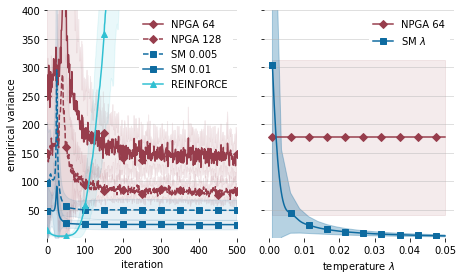

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 4), sharey=True)

# First plot
path = "/home/kohring/bnelearn/experiments/smooth-new/variance/"
experiments = [dp for dp, _, filenames in os.walk(path) for f in filenames
               if os.path.splitext(f)[1] == '.json' and "experiment_configurations" in f]
markevery = 50
for i, path in enumerate(experiments):
    
    # Load config
    with open(path + "/experiment_configurations.json") as f:
        config = json.load(f)
    label = config["learning"]["learner_type"]
    if label == "ESPGLearner":
        population_size = config["learning"]["learner_hyperparams"]["population_size"]
        label = "NPGA " + str(population_size)
        color, linestyle = COLORS[1], "-D" if population_size == 64 else "--D"
    elif label == "PGLearner":
        temperature = config["learning"]["smoothing_temperature"]
        label = "SM " + str(temperature)
        color, linestyle = COLORS[0], "-s" if temperature == 0.01 else "--s"
    else:
        label = "REINFORCE"
        color, linestyle = COLORS[2], "-^"

    # Load data
    df = pd.read_csv(path + "/full_results.csv")
    df = df[df["tag"] == 'learner_info/gradient_variance']
    df = df.groupby(['epoch']).agg({'value': ['mean', 'std']})
    df.columns = ['means', 'stds']
    
    x = df.index.to_numpy()
    means, stds = df.means.to_numpy(), df.stds.to_numpy()

    axs[0].plot(x, means, linestyle, label=label, color=color, markevery=markevery)
    axs[0].fill_between(x, np.clip(means-stds, 0, 100000), means+stds, color=color, alpha=.1)

axs[0].spines['top'].set_visible(False); axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False); axs[0].spines['left'].set_visible(False)
axs[0].grid(which='major', axis='y', alpha=.5)

axs[0].set_xlabel('iteration'); axs[0].set_ylabel("empirical variance")
axs[0].set_xlim([0, x.max()]); axs[0].set_ylim([1, 400]); #axs[0].semilogy()
axs[0].legend(loc='upper right', ncol=1, framealpha=1, edgecolor="white")

# Second plot
markevery = 2
for i, label in zip([1, 0], ["NPGA", "SM"]):
    if label == "NPGA":
        for p, population_size in enumerate(population_sizes):
            axs[1].plot(temperatures, variance_mean[i, :, p], '-D', label=label + f" {population_size}",
                       color=COLORS[i], markevery=markevery
                       )
            axs[1].fill_between(temperatures, variance_mean[i, :, p]-variance_std[i, :, p],
                                variance_mean[i, :, p]+variance_std[i, :, p], alpha=.1, color=COLORS[i])
    else:
        axs[1].plot(temperatures, variance_mean[i, :, 0], 's',
                    color=COLORS[i], markevery=markevery
                    )
        axs[1].fill_between(temperatures, variance_mean[i, :, 0]-variance_std[i, :, 0],
                            variance_mean[i, :, 0]+variance_std[i, :, 0], alpha=.3, color=COLORS[i])
        
        from scipy import interpolate
        smoothing_inter = np.linspace(temperatures[0], temperatures[-1], len(temperatures)*10)
        means_inter = interpolate.interp1d(temperatures, variance_mean[i, :, 0], kind='cubic')(smoothing_inter)
        axs[1].plot(smoothing_inter, means_inter, "-s", label=label + " $\lambda$",
                    color=COLORS[i], markevery=1e100)


# Formatting
axs[1].set_xlabel('temperature $\lambda$'); # axs[1].set_ylabel("empirical variance")
# axs[1].yscale('log'); axs[1].set_xlim(0, 0.015); axs[1].set_ylim(0, 60)
axs[1].spines['top'].set_visible(False); axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False); axs[1].spines['left'].set_visible(False)
axs[1].legend(loc='upper right', ncol=1, framealpha=1, edgecolor="white")
axs[1].grid(which='major', axis='y', alpha=.5)

plt.tight_layout(); plt.savefig('variance-analysis.pdf'); plt.savefig('variance-analysis.png', dpi=300)
plt.show()